### Przygotowanie zbioru do modelu

In [1]:
import pandas as pd
import json
from pyspark.sql import functions as F
from pyspark.sql.functions import col


In [2]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("xT_preprocessing") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Do stworzenia modelu prototypowego korzystam z samych danych z ligi włoskiej za sezon 2015-16. W późniejszej wersji będę korzystał z danych z lig top5 co da mi około 5 razy więcej danych.

In [3]:
# Load data
df = spark.read.parquet('data/all_events_combined_2015_2016.parquet')

# Basic info
print(f"Total events: {df.count():,}")
print(f"Columns: {len(df.columns)}")

Total events: 6,391,338
Columns: 120


Wybrałem zmienne potrzebne do stworzenia zbioru danych dla późniejszego modelu:
- **match_id**, **possession** - do identyfikacji posiadania piłki
- **team** - drużyna, która wykonała dane zagranie
- **possession_team** - drużyna, która jest właścicielem aktualnego posiadania, przeprowadza akcję; zwykle tożsame z **team**, ale nie zawsze bo jeśli drużyna X przeprowadza akcję i drużyna Y na chwilę przejmie piłkę, ale jej nie opanuje i drużyna X błyskawicznie ją odzyska kontynuując akcję to wartości zmiennej **team** będą się zmieniać, ale **possession_team** nie. Przybliżona definicja possession to sekwencja zagrań jednej drużyny przerwana faulem, utratą piłki (min. 2 kolejne kontakty przecwinika), strzałem
- **index** - do numeracji kolejności zdarzeń w ramach jednej akcji
- **type** - rodzaj eventu
- **location** - współrzędne początkowo eventu
- **pass_end_location** - współrzędne dokąd zostało posłane podanie
- **shot_outcome** - rezultat strzału

In [4]:
# Wybieram potrzebne kolumny
df_filtered = df.select(
    'match_id', # do identyfikacji - wraz z possession stanowią identyfikator danwej posesji (posiadania piłki)
    'possession', # do identyfikacji posesji
    'team',
    'possession_team', # nie zawsze jest tożsamy z team - jeśli drużyna X prowadzi akcję i na chwilę piłkę przejmie drużyna Y (ale nie opanuje trwale piłki) to zmienna "team" =
    'index',
    'type',
    'location',
    'pass_end_location',
    # 'carry_end_location',
    'shot_outcome'
)

print(f"Columns reduced from {len(df.columns)} to {len(df_filtered.columns)}")
df_filtered.show(10)

Columns reduced from 120 to 9
+--------+----------+--------+---------------+-----+-----------+------------+-----------------+------------+
|match_id|possession|    team|possession_team|index|       type|    location|pass_end_location|shot_outcome|
+--------+----------+--------+---------------+-----+-----------+------------+-----------------+------------+
| 3879863|         1|Atalanta|       Atalanta|    1|Starting XI|        NULL|             NULL|        NULL|
| 3879863|         1| Udinese|       Atalanta|    2|Starting XI|        NULL|             NULL|        NULL|
| 3879863|         1| Udinese|       Atalanta|    3| Half Start|        NULL|             NULL|        NULL|
| 3879863|         1|Atalanta|       Atalanta|    4| Half Start|        NULL|             NULL|        NULL|
| 3879863|        88| Udinese|       Atalanta| 1839| Half Start|        NULL|             NULL|        NULL|
| 3879863|        88|Atalanta|       Atalanta| 1840| Half Start|        NULL|             NULL|   

Do modelu trafiają finalnie dwa typy zdarzeń: **podania**, które są głównym nośnikiem informacji o generowanym zagrożeniu oraz **strzały** jako kulminacja akcji mówiąca o wyniku, tj. czy padł gol czy nie. W pierwotnej wersji rozważałem jeszcze Carry, ale zwykle rożnica między start_location oraz end_location jest tam na tyle mała że model traktuje to jako szum.

Odfiltrowuje również rzuty karne, które mają bardzo unikalne właściwiości i mogą biasować model.

In [5]:
# Filter movement events only
movement_types = ['Pass', 'Shot']

df_movement = df_filtered.filter(
    df_filtered['type'].isin(movement_types)
)

df_movement = df_movement.filter(
    (F.col("type") != "Shot") | 
    (F.col("shot_type").isNull()) |
    (F.col("shot_type") != "Penalty")
)

print(f"Events before filter: {df_filtered.count():,}")
print(f"Events after filters: {df_movement.count():,}")
print(f"Kept: {df_movement.count() / df_filtered.count() * 100:.1f}%")

# Show distribution
print("\nEvent type distribution:")
df_movement.groupBy('type').count().orderBy('count', ascending=False).show()

Events before filter: 6,391,338
Events after filters: 1,822,645
Kept: 28.5%

Event type distribution:
+----+-------+
|type|  count|
+----+-------+
|Pass|1777412|
|Shot|  45233|
+----+-------+



In [6]:
df_movement.filter(col("shot_outcome")=="Goal").count() #ile mam goli w zbiorze

4338

W danych Statsbomb lokalizacja jest podawana z perspektywy drużyny, która jest w zmiennej **team** (jakby atakowała w kierunku x=120). W związku z tym jeśli w ramach posiadania piłki drużyny X jakieś zagranie wykona zawodnik drużyny Y to lokalizacja jest odwracana - w moich danych muszę to ponowanie odwrócić.

In [7]:
from pyspark.sql import functions as F

df_movement = df_movement.withColumn(
    "location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("location")[0], 1),
            F.round(F.lit(80) - F.col("location")[1], 1)
        )
    ).otherwise(F.col("location"))
).withColumn(
    "pass_end_location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("pass_end_location")[0], 1),
            F.round(F.lit(80) - F.col("pass_end_location")[1], 1)
        )
    ).otherwise(F.col("pass_end_location"))
)

In [8]:
from pyspark.sql.functions import col
df_movement.filter((col('match_id')==3879863) &(col('possession')==2)).orderBy("index").show()

+--------+----------+--------+---------------+-----+----+------------+-----------------+------------+
|match_id|possession|    team|possession_team|index|type|    location|pass_end_location|shot_outcome|
+--------+----------+--------+---------------+-----+----+------------+-----------------+------------+
| 3879863|         2|Atalanta|       Atalanta|    5|Pass|[61.0, 40.1]|     [58.7, 42.1]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|    8|Pass|[57.6, 42.1]|     [35.5, 46.4]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|   11|Pass|[37.3, 46.2]|     [78.1, 10.2]|        NULL|
| 3879863|         2| Udinese|       Atalanta|   13|Pass|[78.0, 10.1]|     [67.3, 40.3]|        NULL|
| 3879863|         2| Udinese|       Atalanta|   15|Pass|[66.7, 40.3]|     [66.0, 46.5]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|   25|Pass|[76.0, 75.7]|     [84.7, 71.2]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|   29|Pass|[81.5, 71.0]|     [65.5, 

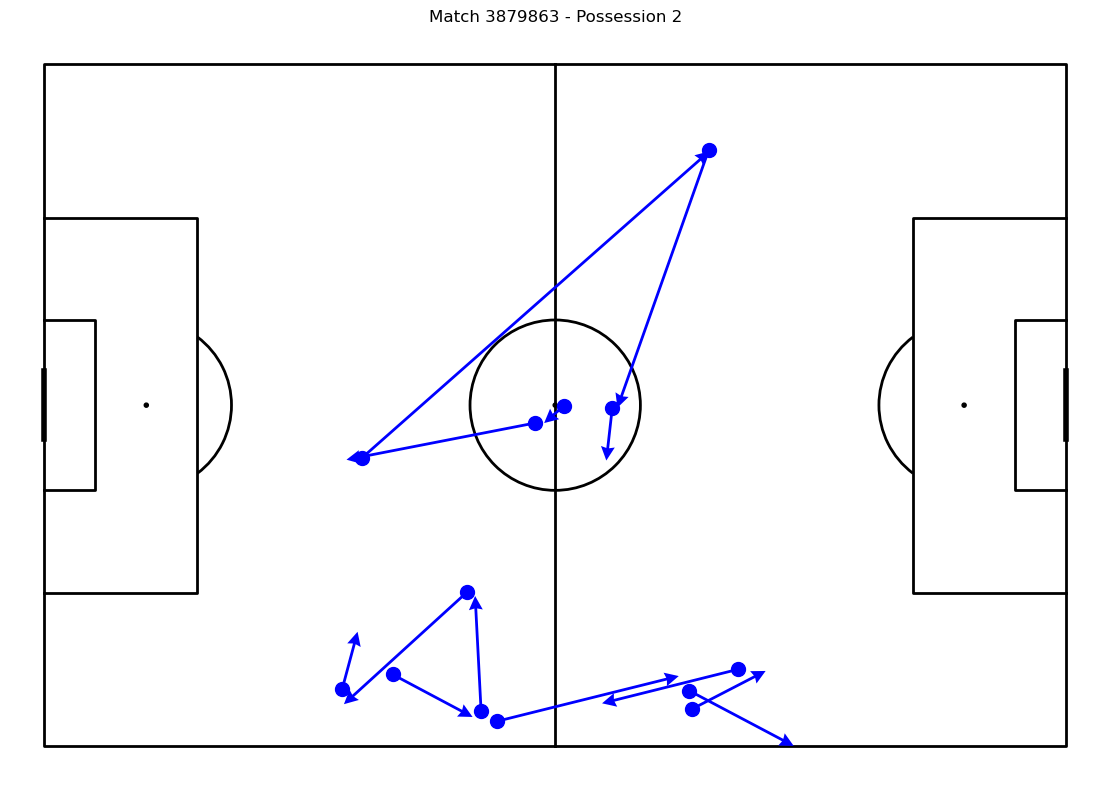

In [9]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Filtruj po match_id i possession
match_id = 3879863  # twoje match_id
possession_num = 2
df_action = df_movement.filter(
    (df_movement.match_id == match_id) & (df_movement.possession == possession_num)
).orderBy('index').toPandas()

pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

colors = {'Pass': 'blue', 'Carry': 'grey', 'Shot': 'red'}

for idx, row in df_action.iterrows():
    event_type = row['type']
    start = row['location']
    
    # Pobierz end_location
    end = row['pass_end_location']

    
    # Sprawdź czy end istnieje (None sprawdza się normalnie)
    if end is None:
        continue
    
    # Strzałka
    pitch.arrows(start[0], start[1], end[0], end[1],
                 ax=ax, color=colors.get(event_type, 'gray'),
                 width=2, headwidth=5, headlength=5)
    
    # Punkt startowy
    pitch.scatter(start[0], start[1], ax=ax, 
                  color=colors.get(event_type, 'gray'), 
                  s=100, zorder=3)

# Shot marker
shots = df_action[df_action['type'] == 'Shot']
if not shots.empty:
    for _, shot in shots.iterrows():
        pitch.scatter(shot['location'][0], shot['location'][1],
                     ax=ax, color='red', s=300, 
                     marker='*', zorder=4)

plt.title(f'Match {match_id} - Possession {possession_num}')
plt.tight_layout()
plt.show()

In [10]:
# Policz długość każdej posesji
possession_lengths = df_movement.groupBy('match_id', 'possession').count()

# Statystyki
print("=== POSSESSION LENGTH STATISTICS ===")
possession_lengths.select('count').describe().show()

# Percentyle
print("\n=== PERCENTILES ===")
possession_lengths.selectExpr(
    "percentile_approx(count, 0.50) as p50_median",
    "percentile_approx(count, 0.75) as p75",
    "percentile_approx(count, 0.80) as p80",
    "percentile_approx(count, 0.90) as p90",
    "percentile_approx(count, 0.95) as p95",
    "percentile_approx(count, 0.99) as p99"
).show()

=== POSSESSION LENGTH STATISTICS ===
+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|           342109|
|   mean|5.327673343875782|
| stddev|5.028557304232468|
|    min|                1|
|    max|              103|
+-------+-----------------+


=== PERCENTILES ===
+----------+---+---+---+---+---+
|p50_median|p75|p80|p90|p95|p99|
+----------+---+---+---+---+---+
|         4|  7|  8| 12| 15| 24|
+----------+---+---+---+---+---+



In [11]:
from pyspark.sql import functions as F

# possession z golem (chociaż jeden wiersz z Goal)
possessions_with_goal = (
    df_movement
        .filter("shot_outcome = 'Goal'")
        .select("match_id", "possession")
        .distinct()
        .withColumn("goal", F.lit(1))
)

possession_with_lengths_and_goal = (
    possession_lengths
        .join(possessions_with_goal, on=["match_id", "possession"], how="left")
        .withColumn("goal", F.when(F.col("goal").isNull(), 0).otherwise(1))
)

# Dodajemy kolumnę z długością, gdzie >12 = "13+"
possession_binned = (
    possession_with_lengths_and_goal
        .withColumn(
            "count_group",
            F.when(F.col("count") > 12, F.lit("13+"))
             .otherwise(F.col("count").cast("string"))
        )
)

# Agregacja po zbinowanej długości
goal_length_stats_binned = (
    possession_binned
        .groupBy("count_group")
        .agg(
            F.sum("goal").alias("num_goals"),
            F.count("*").alias("total_possessions")
        )
        .orderBy(
            F.when(F.col("count_group") == "13+", 999)
             .otherwise(F.col("count_group").cast("int"))
        )
)

goal_length_stats_binned.show(100)

+-----------+---------+-----------------+
|count_group|num_goals|total_possessions|
+-----------+---------+-----------------+
|          1|      147|            61134|
|          2|      680|            52083|
|          3|      580|            48849|
|          4|      481|            36275|
|          5|      391|            28117|
|          6|      342|            21883|
|          7|      306|            17434|
|          8|      234|            14033|
|          9|      182|            11299|
|         10|      179|             9123|
|         11|      111|             7316|
|         12|      109|             6035|
|        13+|      596|            28528|
+-----------+---------+-----------------+



Ponieważ akcje mogą mieć bardzo różną długośc (od 1 do 103) ustawiam maksymalną **długość na 12**. Dla akcji dłuższych odcinam zdarzenia początkowe, aby zostało maksymalnie 12 ostatnich zdarzeń w ramach akcji.

In [12]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, col

MAX_SEQUENCE_LENGTH = 12

# Define window: partition by possession, order by index DESCENDING (od końca!)
window_spec = Window.partitionBy('match_id', 'possession').orderBy(desc('index'))

# Numeruj eventy od końca (1 = ostatni event, 2 = przedostatni, etc.)
df_numbered = df_movement.withColumn(
    'event_rank',
    row_number().over(window_spec)
)

# Filtruj: zostaw tylko ostatnie 12 eventów
df_truncated = df_numbered.filter(col('event_rank') <= MAX_SEQUENCE_LENGTH)

print(f"\n=== TRUNCATION RESULTS ===")
print(f"Events before: {df_numbered.count():,}")
print(f"Events after: {df_truncated.count():,}")
print(f"Removed: {df_numbered.count() - df_truncated.count():,}")


=== TRUNCATION RESULTS ===
Events before: 1,822,645
Events after: 1,651,285
Removed: 171,360


In [13]:
df_truncated.show(20)

+--------+----------+---------+---------------+-----+----+-------------+-----------------+------------+----------+
|match_id|possession|     team|possession_team|index|type|     location|pass_end_location|shot_outcome|event_rank|
+--------+----------+---------+---------------+-----+----+-------------+-----------------+------------+----------+
|  265839|        27|  Sevilla|        Sevilla|  605|Pass| [40.0, 64.8]|     [36.5, 60.6]|        NULL|         1|
|  265839|        27|  Sevilla|        Sevilla|  601|Pass| [28.0, 57.5]|     [44.8, 59.3]|        NULL|         2|
|  265839|        27|  Sevilla|        Sevilla|  598|Pass| [30.8, 51.8]|     [27.9, 57.4]|        NULL|         3|
|  265839|        27|  Sevilla|        Sevilla|  594|Pass| [26.1, 58.8]|     [31.1, 51.4]|        NULL|         4|
|  265839|        74|Barcelona|      Barcelona| 1962|Pass| [50.7, 63.3]|     [49.1, 51.9]|        NULL|         1|
|  265839|        74|Barcelona|      Barcelona| 1959|Pass| [42.8, 76.6]|     [47

In [14]:
# rozbijam location i pass_end_location na x oraz y
from pyspark.sql.functions import col

df_with_coords = (
    df_truncated
        .withColumn("x", col("location").getItem(0).cast("double"))
        .withColumn("y", col("location").getItem(1).cast("double"))
        .withColumn("end_x", col("pass_end_location").getItem(0).cast("double"))
        .withColumn("end_y", col("pass_end_location").getItem(1).cast("double"))
)

df_with_coords.show(5)

+--------+----------+---------+---------------+-----+----+------------+-----------------+------------+----------+----+----+-----+-----+
|match_id|possession|     team|possession_team|index|type|    location|pass_end_location|shot_outcome|event_rank|   x|   y|end_x|end_y|
+--------+----------+---------+---------------+-----+----+------------+-----------------+------------+----------+----+----+-----+-----+
|  265839|        27|  Sevilla|        Sevilla|  605|Pass|[40.0, 64.8]|     [36.5, 60.6]|        NULL|         1|40.0|64.8| 36.5| 60.6|
|  265839|        27|  Sevilla|        Sevilla|  601|Pass|[28.0, 57.5]|     [44.8, 59.3]|        NULL|         2|28.0|57.5| 44.8| 59.3|
|  265839|        27|  Sevilla|        Sevilla|  598|Pass|[30.8, 51.8]|     [27.9, 57.4]|        NULL|         3|30.8|51.8| 27.9| 57.4|
|  265839|        27|  Sevilla|        Sevilla|  594|Pass|[26.1, 58.8]|     [31.1, 51.4]|        NULL|         4|26.1|58.8| 31.1| 51.4|
|  265839|        74|Barcelona|      Barcelona| 

In [15]:
from pyspark.sql.functions import when,  struct, array, collect_list, col, lit

# Dodaj event_rank do structa
df_events = df_with_coords.withColumn(
    'is_goal',
    when(col('shot_outcome') == 'Goal', 1).otherwise(0).cast('int')
).withColumn(
    'event',
    struct(
        col('event_rank').alias('rank'),
        col('type').alias('type'),
        col('x').alias('x'),
        col('y').alias('y'),
        col('end_x').alias('end_x'),
        col('end_y').alias('end_y'),
        col('is_goal').alias('is_goal')
    )
)

# Agreguj
sequences = df_events.groupBy('match_id', 'possession').agg(
    collect_list('event').alias('events')
)

# Sortuj array po rank (DESC -> ASC, żeby było chronologicznie)
from pyspark.sql.functions import array_sort, expr

sequences = sequences.withColumn(
    'events',
    expr("array_sort(events, (left, right) -> case when left.rank < right.rank then 1 else -1 end)")
)

sequences.show(3, truncate=False)

+--------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|match_id|possession|events                                                                                                                                                    |
+--------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|265839  |27        |[{4, Pass, 26.1, 58.8, 31.1, 51.4, 0}, {3, Pass, 30.8, 51.8, 27.9, 57.4, 0}, {2, Pass, 28.0, 57.5, 44.8, 59.3, 0}, {1, Pass, 40.0, 64.8, 36.5, 60.6, 0}]  |
|265839  |74        |[{3, Pass, 41.5, 72.5, 42.8, 76.6, 0}, {2, Pass, 42.8, 76.6, 47.9, 67.1, 0}, {1, Pass, 50.7, 63.3, 49.1, 51.9, 0}]                                        |
|265839  |77        |[{4, Pass, 70.0, 24.5, 83.5, 55.6, 0}, {3, Pass, 83.5, 55.6, 82.3, 61.4, 0}, {2, Pass, 90.2, 6

In [16]:
df_with_coords.select("team", "type", "location","pass_end_location", "shot_outcome").filter((col('possession') == 27) & (col('match_id') == 265839)).show(truncate=False)

+-------+----+------------+-----------------+------------+
|team   |type|location    |pass_end_location|shot_outcome|
+-------+----+------------+-----------------+------------+
|Sevilla|Pass|[40.0, 64.8]|[36.5, 60.6]     |NULL        |
|Sevilla|Pass|[28.0, 57.5]|[44.8, 59.3]     |NULL        |
|Sevilla|Pass|[30.8, 51.8]|[27.9, 57.4]     |NULL        |
|Sevilla|Pass|[26.1, 58.8]|[31.1, 51.4]     |NULL        |
+-------+----+------------+-----------------+------------+



In [17]:
from pyspark.sql.functions import max as spark_max, size

# Zidentyfikuj czy posesja kończy się golem
sequences = sequences.withColumn(
    'goal',
    expr("aggregate(events, 0, (acc, x) -> acc + x.is_goal)").cast('int')
)

sequences.select('match_id', 'possession', 'goal', 'events').show(3, truncate=False)

+--------+----------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|match_id|possession|goal|events                                                                                                                                                    |
+--------+----------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------+
|265839  |27        |0   |[{4, Pass, 26.1, 58.8, 31.1, 51.4, 0}, {3, Pass, 30.8, 51.8, 27.9, 57.4, 0}, {2, Pass, 28.0, 57.5, 44.8, 59.3, 0}, {1, Pass, 40.0, 64.8, 36.5, 60.6, 0}]  |
|265839  |74        |0   |[{3, Pass, 41.5, 72.5, 42.8, 76.6, 0}, {2, Pass, 42.8, 76.6, 47.9, 67.1, 0}, {1, Pass, 50.7, 63.3, 49.1, 51.9, 0}]                                        |
|265839  |77        |0   |[{4, Pass, 70.0, 24.5, 83.5, 55.6, 0}, {3, Pass, 83.5, 55.6, 82.

In [18]:
# Dodaj end token na koniec
sequences = sequences.withColumn(
    'end_event',
    struct(
        lit(0).alias('rank'),  # na początek przy sortowaniu
        when(col('goal') == 1, lit('GOAL')).otherwise(lit('NO_GOAL')).alias('type'),
        lit(None).cast('double').alias('x'),
        lit(None).cast('double').alias('y'),
        lit(None).cast('double').alias('end_x'),
        lit(None).cast('double').alias('end_y'),
        col('goal').alias('is_goal')
    )
)

sequences = sequences.withColumn(
    'events',
    expr("concat(events, array(end_event))")
)

# Dodaj sequence_length
sequences = sequences.withColumn(
    'sequence_length',
    size('events')
)

# Finalne kolumny
sequences_final = sequences.select(
    'match_id', 'possession', 'events', 'sequence_length', 'goal'
)

sequences_final.show(3, truncate=False)

+--------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----+
|match_id|possession|events                                                                                                                                                                                             |sequence_length|goal|
+--------+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----+
|265839  |27        |[{4, Pass, 26.1, 58.8, 31.1, 51.4, 0}, {3, Pass, 30.8, 51.8, 27.9, 57.4, 0}, {2, Pass, 28.0, 57.5, 44.8, 59.3, 0}, {1, Pass, 40.0, 64.8, 36.5, 60.6, 0}, {0, NO_GOAL, NULL, NULL, NULL, NULL, 0}]  |5              |0   |
|265839  |74        |[{3, Pass, 41.5, 72.5, 

In [19]:
print("=== STATISTICS ===")
sequences_final.select('sequence_length').describe().show()
sequences_final.groupBy('goal').count().show()
print(f"Total: {sequences_final.count():,}")

=== STATISTICS ===
+-------+-----------------+
|summary|  sequence_length|
+-------+-----------------+
|  count|           342109|
|   mean|5.826780353629983|
| stddev|3.525468190777938|
|    min|                2|
|    max|               13|
+-------+-----------------+

+----+------+
|goal| count|
+----+------+
|   1|  4338|
|   0|337771|
+----+------+

Total: 342,109


In [20]:
# Undersample do 5% goli
goals = sequences_final.filter(col('goal') == 1)
non_goals = sequences_final.filter(col('goal') == 0)

n_goals = goals.count()
sample_fraction = (n_goals / 0.05 - n_goals) / non_goals.count()

balanced = goals.union(non_goals.sample(fraction=sample_fraction, seed=42))

print(f"Total: {balanced.count():,}")
balanced.groupBy('goal').count().show()

Total: 86,602
+----+-----+
|goal|count|
+----+-----+
|   1| 4338|
|   0|82264|
+----+-----+



In [21]:
# Usuń rank z eventów (nie potrzebny w finalnym zbiorze)
from pyspark.sql.functions import transform, round as spark_round

df_normalized = balanced.withColumn(
    'events',
    transform('events', lambda e: struct(
        e.type.alias('type'),
        spark_round(e.x / 120.0, 5).alias('x'),
        spark_round(e.y / 80.0, 5).alias('y'),
        spark_round(e.end_x / 120.0, 5).alias('end_x'),
        spark_round(e.end_y / 80.0, 5).alias('end_y')
    ))
)

In [22]:
df_normalized.count()

86602

In [23]:
# Konwertuj do pandas
df_pandas = df_normalized.toPandas()

# Zapisz
df_pandas.to_parquet('data/sequences_continuous_balanced.parquet', index=False)
print(f"✅ Saved {len(df_pandas):,} sequences")

✅ Saved 86,602 sequences


In [24]:
df = pd.read_parquet('data/sequences_continuous_balanced.parquet')
print(f"Loaded: {len(df):,} sequences")
print(f"Goals: {df['goal'].sum()} ({df['goal'].mean()*100:.1f}%)")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst sequence structure:")
print(df['events'].iloc[0])

Loaded: 86,602 sequences
Goals: 4338 (5.0%)

Columns: ['match_id', 'possession', 'events', 'sequence_length', 'goal']

First sequence structure:
[{'end_x': 0.93, 'end_y': 0.5225, 'type': 'Pass', 'x': 0.70833, 'y': 0.3275}
 {'end_x': None, 'end_y': None, 'type': 'Shot', 'x': 0.895, 'y': 0.42625}
 {'end_x': None, 'end_y': None, 'type': 'GOAL', 'x': None, 'y': None}]


In [25]:
type_vocab = {
    'Pass': 0, 
    'Shot': 1,
    'GOAL': 2,
    'NO_GOAL': 3,
    '<pad>': 4
}

# Zapisz
with open('data/vocab_continuous.json', 'w') as f:
    json.dump(type_vocab, f, indent=2)

id_to_type = {v: k for k, v in type_vocab.items()}
with open('data/id_to_type_continuous.json', 'w') as f:
    json.dump(id_to_type, f, indent=2)

print(f"✅ Vocabulary size: {len(type_vocab)}")

✅ Vocabulary size: 5


In [26]:
# Sprawdź czy pliki istnieją:
import os

files_needed = [
    'data/sequences_continuous_balanced.parquet',
    'data/vocab_continuous.json',
    'data/id_to_type_continuous.json'
]

for f in files_needed:
    if os.path.exists(f):
        print(f"✅ {f}")
    else:
        print(f"❌ {f} - MISSING!")

✅ data/sequences_continuous_balanced.parquet
✅ data/vocab_continuous.json
✅ data/id_to_type_continuous.json
